In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# Plot Time Series Graph
def plot_time_series(time, series, format='-', start=0, end=None, label=None):
  plt.plot(time[start:end], series[start:end], format, label=label)
  plt.xlabel('Time')
  plt.ylabel('Value')
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)  

# To generate trend
def trend(time, slope=0):
  return time * slope

# To generate Seasonal Pattern
def seasonal_pattern(season_time):
  return np.where(season_time < 0.4,
                  np.cos(season_time * 2 * np.pi),
                  1 / np.exp(3 * season_time))
  
# To generate seasonality data
def seasonality(time, period, amplitude=1, phase=0):
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)

# To generate noise
def white_noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level


def window_dataset(series, window_size, batch_size=32, shuffle_buffer=1000):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(size=window_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
  dataset = dataset.shuffle(shuffle_buffer)
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  
  return dataset


def model_forecast(model, series, window_size):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda w: w.batch(window_size))
  dataset = dataset.batch(32).prefetch(1)
  forecast = model.predict(dataset)

  return forecast

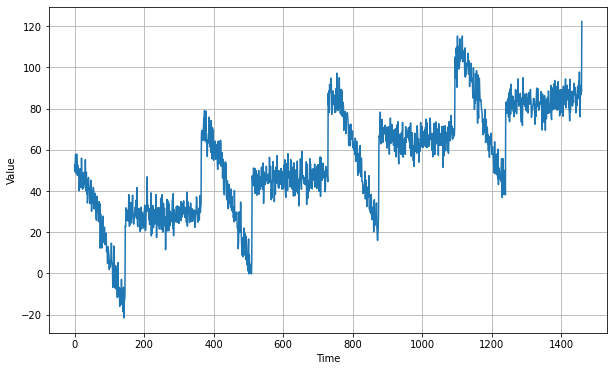

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level=noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_time_series(time, series)
plt.show()

In [4]:
split_time = 1000

time_train = time[:split_time]
time_valid = time[split_time:]

x_train = series[:split_time]
x_valid = series[split_time:]

In [5]:
len(x_train), len(x_valid)

(1000, 461)

In [6]:
x_train.shape, x_valid.shape

((1000,), (461,))

# Simple RNN Forecasting

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

WINDOW_SIZE = 30
train_set = window_dataset(x_train, window_size=WINDOW_SIZE, batch_size=128)
train_set


<PrefetchDataset shapes: ((None, None), (None, None)), types: (tf.float64, tf.float64)>

In [8]:
for x,y in train_set.take(1):
  print(x.shape, y.shape)

(128, 30) (128, 1)


In [9]:
x.shape

TensorShape([128, 30])

In [10]:
tf.expand_dims(x, axis=-1).shape

TensorShape([128, 30, 1])

In [11]:
rnn_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.SimpleRNN(100, return_sequences=True),
    tf.keras.layers.SimpleRNN(100),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*200.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch/20)
)

rnn_model.compile(
    loss = tf.keras.losses.Huber(),
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9),
    metrics = ['mae']
)

rnn_history = rnn_model.fit(train_set,
                            epochs=100,
                            callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 2s 46ms/step - loss: 50.2719 - mae: 50.7719
Epoch 2/100
8/8 [==============================] - 0s 41ms/step - loss: 22.3951 - mae: 22.8885
Epoch 3/100
8/8 [==============================] - 0s 38ms/step - loss: 18.8189 - mae: 19.3113
Epoch 4/100
8/8 [==============================] - 0s 36ms/step - loss: 17.2973 - mae: 17.7880
Epoch 5/100
8/8 [==============================] - 0s 38ms/step - loss: 15.8422 - mae: 16.3327
Epoch 6/100
8/8 [==============================] - 0s 36ms/step - loss: 14.9965 - mae: 15.4864
Epoch 7/100
8/8 [==============================] - 0s 34ms/step - loss: 14.4474 - mae: 14.9364
Epoch 8/100
8/8 [==============================] - 0s 33ms/step - loss: 14.1676 - mae: 14.6549
Epoch 9/100
8/8 [==============================] - 0s 33ms/step - loss: 13.9686 - mae: 14.4566
Epoch 10/100
8/8 [==============================] - 0s 31ms/step - loss: 13.7369 - mae: 14.2232
Epoch 11/100
8/8 [==============================]

(1e-07, 0.0001, 0.0, 30.0)

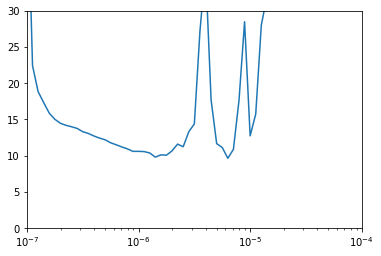

In [13]:
plt.semilogx(rnn_history.history['lr'], rnn_history.history['loss'])
plt.axis([1e-7, 1e-4, 0, 30])

In [14]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

WINDOW_SIZE = 30
train_set = window_dataset(x_train, window_size=WINDOW_SIZE, batch_size=128)
valid_set = window_dataset(x_valid, window_size=WINDOW_SIZE, batch_size=128)

rnn_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.SimpleRNN(100, return_sequences=True),
    tf.keras.layers.SimpleRNN(100),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*200.0)
])

rnn_model.compile(
    loss = tf.keras.losses.Huber(),
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9),
    metrics = ['mae']
)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('rnn_model_checkpoint', 
                                                      save_best_only=True)
rnn_history = rnn_model.fit(train_set,
                            epochs=100,
                            validation_data=valid_set,
                            callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
8/8 [==============================] - 3s 102ms/step - loss: 76.9368 - mae: 77.4364 - val_loss: 76.1147 - val_mae: 76.6147
INFO:tensorflow:Assets written to: rnn_model_checkpoint/assets
Epoch 2/100
8/8 [==============================] - 1s 65ms/step - loss: 32.0930 - mae: 32.5895 - val_loss: 18.1689 - val_mae: 18.6645
INFO:tensorflow:Assets written to: rnn_model_checkpoint/assets
Epoch 3/100
8/8 [==============================] - 1s 53ms/step - loss: 33.4488 - mae: 33.9466 - val_loss: 21.7679 - val_mae: 22.2606
Epoch 4/100
8/8 [==============================] - 1s 49ms/step - loss: 25.1501 - mae: 25.6478 - val_loss: 43.2917 - val_mae: 43.7916
Epoch 5/100
8/8 [==============================] - 1s 49ms/step - loss: 24.7289 - mae: 25.2227 - val_loss: 31.0703 - val_mae: 31.5693
Epoch 6/100
8/8 [==============================] - 1s 52ms/step - loss: 22.1780 - mae: 22.6718 - val_loss: 22.2411 - val_mae: 22.7382
Epoch 7/100
8/8 [==============================] - 1s 51ms/step - los

In [15]:
rnn_model = tf.keras.models.load_model('rnn_model_checkpoint')

In [16]:
rnn_forecast = model_forecast(model=rnn_model,
                              series=series[split_time - WINDOW_SIZE : -1], window_size=WINDOW_SIZE)

In [22]:
rnn_forecast.shape

(461, 1)

In [23]:
rnn_forecast[:,0].shape

(461,)

In [24]:
rnn_forecast = rnn_forecast[:,0]

In [25]:
rnn_model_mae = tf.keras.metrics.mean_absolute_error(y_true=x_valid,
                                                     y_pred=rnn_forecast)
rnn_model_mae

<tf.Tensor: shape=(), dtype=float32, numpy=5.7516575>

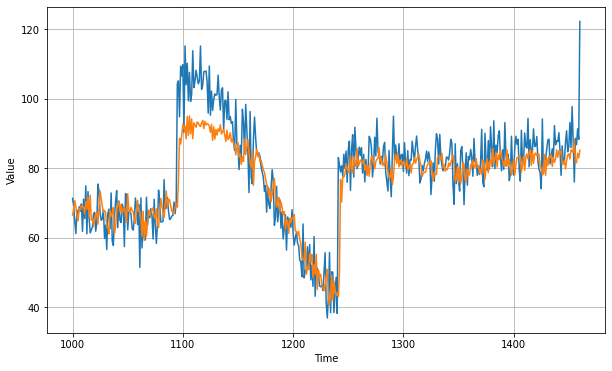

In [26]:
plt.figure(figsize=(10, 6))
plot_time_series(time_valid, x_valid)
plot_time_series(time_valid, rnn_forecast)

# 2- Sequence to Sequence Forecasting

In [28]:
def seq2seq_windows_dataset(series, window_size, batch_size=32, shuffle_buffer=1000):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda w: w.batch(window_size+1))
  dataset = dataset.shuffle(shuffle_buffer)
  dataset = dataset.map(lambda w: (w[:-1], w[1:]))
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

In [31]:
for X_batch, Y_batch in seq2seq_windows_dataset(tf.range(10), 3, batch_size=1):
  print('X_batch', X_batch.numpy())
  print('Y_batch', Y_batch.numpy())

X_batch [[[6]
  [7]
  [8]]]
Y_batch [[[7]
  [8]
  [9]]]
X_batch [[[0]
  [1]
  [2]]]
Y_batch [[[1]
  [2]
  [3]]]
X_batch [[[3]
  [4]
  [5]]]
Y_batch [[[4]
  [5]
  [6]]]
X_batch [[[1]
  [2]
  [3]]]
Y_batch [[[2]
  [3]
  [4]]]
X_batch [[[2]
  [3]
  [4]]]
Y_batch [[[3]
  [4]
  [5]]]
X_batch [[[5]
  [6]
  [7]]]
Y_batch [[[6]
  [7]
  [8]]]
X_batch [[[4]
  [5]
  [6]]]
Y_batch [[[5]
  [6]
  [7]]]


In [35]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

WINDOW_SIZE = 30
train_set = seq2seq_windows_dataset(x_train, window_size=WINDOW_SIZE, batch_size=128)
train_set

seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(100, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(100, return_sequences=True),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*200)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch/30)
)

seq2seq_model.compile(
    loss = tf.keras.losses.Huber(),
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9),
    metrics = ['mae']
)

seq2seq_history = seq2seq_model.fit(train_set,
                                    epochs=100,
                                    callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 2s 34ms/step - loss: 52.3615 - mae: 52.8611
Epoch 2/100
8/8 [==============================] - 0s 34ms/step - loss: 25.4713 - mae: 25.9671
Epoch 3/100
8/8 [==============================] - 0s 38ms/step - loss: 23.5029 - mae: 23.9971
Epoch 4/100
8/8 [==============================] - 0s 38ms/step - loss: 21.1367 - mae: 21.6294
Epoch 5/100
8/8 [==============================] - 0s 39ms/step - loss: 19.4762 - mae: 19.9674
Epoch 6/100
8/8 [==============================] - 0s 37ms/step - loss: 18.6742 - mae: 19.1647
Epoch 7/100
8/8 [==============================] - 0s 34ms/step - loss: 18.1698 - mae: 18.6587
Epoch 8/100
8/8 [==============================] - 0s 37ms/step - loss: 17.7679 - mae: 18.2568
Epoch 9/100
8/8 [==============================] - 0s 37ms/step - loss: 17.4389 - mae: 17.9280
Epoch 10/100
8/8 [==============================] - 0s 43ms/step - loss: 17.0989 - mae: 17.5875
Epoch 11/100
8/8 [==============================]

(1e-07, 0.0001, 0.0, 30.0)

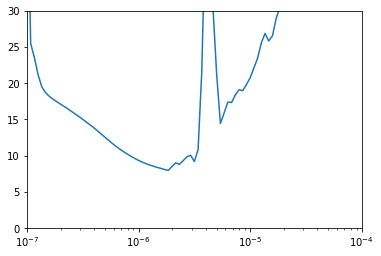

In [36]:
plt.semilogx(se2seq_history.history['lr'], seq2seq_history.history['loss'])
plt.axis([1e-7, 1e-4, 0, 30])

In [37]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

WINDOW_SIZE = 30
train_set = seq2seq_windows_dataset(x_train, window_size=WINDOW_SIZE, batch_size=128)
valid_set = seq2seq_windows_dataset(x_valid, window_size=WINDOW_SIZE, batch_size=128)

seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(100, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(100, return_sequences=True),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*200.0)
])

seq2seq_model.compile(
    loss = tf.keras.losses.Huber(),
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9),
    metrics = ['mae']
)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)
seq2seq_history = seq2seq_model.fit(train_set,
                                    epochs=100,
                                    validation_data=valid_set,
                                    callbacks=[early_stopping])

Epoch 1/100
8/8 [==============================] - 2s 98ms/step - loss: 54.1428 - mae: 54.6412 - val_loss: 17.9209 - val_mae: 18.4157
Epoch 2/100
8/8 [==============================] - 1s 59ms/step - loss: 34.1721 - mae: 34.6694 - val_loss: 20.5481 - val_mae: 21.0440
Epoch 3/100
8/8 [==============================] - 1s 60ms/step - loss: 27.5074 - mae: 28.0027 - val_loss: 37.8711 - val_mae: 38.3705
Epoch 4/100
8/8 [==============================] - 1s 53ms/step - loss: 21.0646 - mae: 21.5578 - val_loss: 25.2684 - val_mae: 25.7674
Epoch 5/100
8/8 [==============================] - 1s 54ms/step - loss: 17.1768 - mae: 17.6667 - val_loss: 15.3555 - val_mae: 15.8504
Epoch 6/100
8/8 [==============================] - 1s 54ms/step - loss: 15.0382 - mae: 15.5247 - val_loss: 9.4217 - val_mae: 9.9070
Epoch 7/100
8/8 [==============================] - 1s 51ms/step - loss: 13.9508 - mae: 14.4372 - val_loss: 9.1618 - val_mae: 9.6475
Epoch 8/100
8/8 [==============================] - 1s 53ms/step - 

In [38]:
seq2seq_forecast = model_forecast(model=seq2seq_model,
                                  series=series[..., np.newaxis,],
                                  window_size=WINDOW_SIZE)

In [41]:
seq2seq_forecast.shape

(1432, 30, 1)

In [43]:
seq2seq_forecast = seq2seq_forecast[split_time - WINDOW_SIZE: -1, -1, 0]

In [44]:
seq2seq_forecast.shape

(461,)

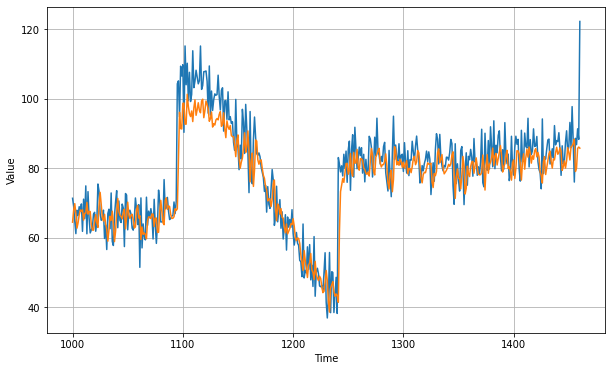

In [45]:
plt.figure(figsize=(10, 6))
plot_time_series(time_valid, x_valid)
plot_time_series(time_valid, seq2seq_forecast)

In [46]:
seq2seq_model_mae = tf.keras.metrics.mean_absolute_error(y_true=x_valid,
                                                         y_pred=seq2seq_forecast)
seq2seq_model_mae

<tf.Tensor: shape=(), dtype=float32, numpy=5.4588637>